# HW1: Алгоритмы Брандеса и Гирвана-Ньюмана

В этом домашнем задании необходимо реализовать [алгоритм Гирвана-Ньюмана](https://en.wikipedia.org/wiki/Girvan%E2%80%93Newman_algorithm) для кластеризации вершин графа (= community detection task). В этом алгоритме ребра с наивысшим значением betweenness centrality итеративно удаляются из графа пока он не развалится на несколько связанных компонент -- эти компоненты и являются целевыми сообществами (т.е. алгоритм опирается на предположение, что если в графе есть несколько сообществ, то соединяющие их ребра будут обладать высокой betweenness centrality)

Вы уже знакомы с определением betweenness centrality для вершин, аналогично определяется betweenness centrality между ребрами: это сумма долей кратчайших путей между всеми парами вершин, проходящих через ребро (то есть ребра с высокой betweenness centrality лежат на большем количестве кратчайших путей между вершинами).
Обратите внимание, что в этом домашнем задании имплементация алгоритма Брандеса и алгоритма Гирвана-Ньюмана **не подразумевает использование сторонних библиотек** (NumPy, SciPy, PyTorch, NetworkX, RustworkX, etc.)

## Часть 1: Алгоритм Брандеса для вычисления betweenness centrality

Сначала необходимо реализовать алгоритм для вычисления  betweenness centrality между ребрами, cамый эффективный из известных на данный момент алгоритмов был предложен Ульриком Брандесом в 2001 году: он описан [здесь](https://www.cl.cam.ac.uk/teaching/1617/MLRD/handbook/brandes.pdf) и [здесь](https://snap.stanford.edu/class/cs224w-readings/brandes01centrality.pdf) (осторожно, оригинальная статья). Обратите внимание, что в материалах из первой ссылки есть упущение: в псевдокоде на странице 4 необходимо дополнительно инициализировать значения $\sigma(s, v)=1$ (если $v = s$) и $\sigma(s, v)=0$ (в иных случаях) в начале каждого прогона BFS.

Можно заметить, что данный алгоритм описывает вычисление betweenness centrality для вершин -- модификация, необходимая для вычисления betweenness centrality ребер, может быть найдна в [еще одной работе Ульрика Брандеса](https://kops.uni-konstanz.de/server/api/core/bitstreams/2762b145-0343-4ba0-a5e5-e7e8348e4a15/content) (см. страницы 10-11 и алгоритм 7).

### Данные

Мы будем использовать сеть цитирований Citeseer -- ее вершинами являются статьи, а ребра соответствуют прецедентам цитирований между публикациями. Для простоты мы будем работать с неориентированной версией этого графа:

In [6]:
from torch_geometric import datasets
from torch_geometric.transforms import LargestConnectedComponents
from win32comext.shell.demos.IActiveDesktop import component

In [7]:
data_citeseer = datasets.Planetoid(name='citeseer', root='data/planetoid',
                                   transform=LargestConnectedComponents(num_components=1))[0]
num_nodes_citeseer = len(data_citeseer.x)
edges_directed_citeseer = data_citeseer.edge_index.T.tolist()
print(edges_directed_citeseer)
print(f'Number of nodes: {num_nodes_citeseer}')
print(f'Number of edges: {len(edges_directed_citeseer) // 2}')   
print(f'Average node degree: {len(edges_directed_citeseer) / num_nodes_citeseer:.2f}')

[[105, 0], [311, 0], [703, 0], [1895, 0], [1907, 0], [423, 1], [115, 2], [665, 2], [1050, 3], [1687, 3], [75, 4], [367, 4], [440, 4], [514, 4], [545, 4], [617, 4], [703, 4], [863, 4], [1022, 4], [1111, 4], [1570, 4], [1582, 4], [743, 5], [951, 5], [1178, 5], [1191, 5], [1760, 5], [201, 6], [406, 6], [409, 6], [651, 6], [902, 6], [985, 6], [1010, 6], [1074, 6], [1355, 6], [1524, 6], [1525, 6], [1526, 6], [1527, 6], [1666, 6], [567, 7], [1341, 7], [383, 8], [505, 8], [527, 8], [848, 9], [922, 9], [2112, 9], [1990, 10], [475, 11], [1334, 11], [2079, 11], [1216, 12], [780, 13], [1264, 13], [1282, 14], [1462, 14], [146, 15], [1773, 15], [151, 16], [492, 16], [650, 16], [817, 16], [902, 16], [1217, 16], [1259, 16], [1261, 16], [1427, 16], [1811, 16], [89, 17], [919, 17], [996, 17], [1055, 17], [1200, 17], [1284, 17], [1447, 17], [1448, 17], [1449, 17], [1450, 17], [1451, 17], [902, 18], [1845, 18], [346, 19], [902, 19], [90, 20], [721, 20], [1023, 20], [1110, 20], [78, 21], [1946, 21], [535,

Сейчас граф представлен в виде списка ребер -- возможно стоит преобразовать его в более удобный формат:

In [8]:
#Ну сделаем список смежности пум, пум, пум!

graph_citeseer = {i: [] for i in range(num_nodes_citeseer)}
for s, t in edges_directed_citeseer:
    graph_citeseer[s].append(t)
    graph_citeseer[t].append(s)

for i in range(num_nodes_citeseer):
    print(f'{i}: {graph_citeseer.get(i, [])}')

0: [105, 311, 703, 1895, 1907, 105, 311, 703, 1895, 1907]
1: [423, 423]
2: [115, 665, 115, 665]
3: [1050, 1687, 1050, 1687]
4: [75, 367, 440, 514, 545, 617, 703, 863, 1022, 1111, 1570, 1582, 75, 367, 440, 514, 545, 617, 703, 863, 1022, 1111, 1570, 1582]
5: [743, 951, 1178, 1191, 1760, 743, 951, 1178, 1191, 1760]
6: [201, 406, 409, 651, 902, 985, 1010, 1074, 1355, 1524, 1525, 1526, 1527, 1666, 201, 406, 409, 651, 902, 985, 1010, 1074, 1355, 1524, 1525, 1526, 1527, 1666]
7: [567, 1341, 567, 1341]
8: [383, 505, 527, 383, 505, 527]
9: [848, 922, 2112, 848, 922, 2112]
10: [1990, 1990]
11: [475, 1334, 2079, 475, 1334, 2079]
12: [1216, 1216]
13: [780, 1264, 780, 1264]
14: [1282, 1462, 1282, 1462]
15: [146, 1773, 146, 1773]
16: [151, 492, 650, 817, 902, 1217, 1259, 1261, 1427, 1811, 151, 492, 650, 817, 902, 1217, 1259, 1261, 1427, 1811]
17: [89, 919, 996, 1055, 1200, 1284, 1447, 1448, 1449, 1450, 1451, 89, 919, 996, 1055, 1200, 1284, 1447, 1448, 1449, 1450, 1451]
18: [902, 1845, 902, 1845]
19:

Реализуйте алгоритм Брандеса в ячейках ниже, функция ```compute_node_and_edge_betweenness``` должна вычислять betweenness centrality как для вершин, так и для ребер:

In [9]:
from collections import deque

In [10]:
#Ну я читать эти pdf, ну вот в одной из них описано (notes_from_cambridge), что и как делать, так что так и делаем так и плывем

def betweenness_bfs(graph, s):
    num_nodes = len(graph)
    
    S = [] #ну тут у нас пройденные/отмеченные вершины
    
    dist = {w: -1 for w in range(num_nodes)} #расстояние между s и w
    preds = {w: [] for w in range(num_nodes)} #предки:3
    sigma = {w: 0 for w in range(num_nodes)} #кол-во кратчайших путей
    
    dist[s] = 0
    sigma[s] = 1
    Q = deque([s]) #пикаем вершину s в очередь
    
    while Q:
        v = Q.popleft()
        S.append(v)
        for w in graph[v]:
            if dist[w] == -1:
                dist[w] = dist[v] + 1
                Q.append(w)
            if dist[w] == dist[v] + 1:
                sigma[w] += sigma[v] 
                preds[w].append(v)
    
    return S, sigma, preds

def compute_node_and_edge_betweenness(graph):
    """
    Compute betweenness centrality for all nodes and edges in the graph.
    
    Returns:
        CB_nodes - a list of length num_nodes that contains all node betweenness centrality values.
            CB_nodes[v] is the centrality of node v for v = 0, ..., num_nodes - 1.
        CB_edges - a dict of length num_edges that contains all edge betweenness centrality values.
            Keys should be node tuples. CB_edges[(u, v)] is the centrality of edge (u, v) for all edges
            in the graph. For each key (u, v), please order nodes such that u < v.
    """
    #А тут мммм, математика, еще и на английском... К слову, лучше на мой взгляд описано в brandes_2008.pdf, собственно использовала алгоритм 2
    num_nodes = len(graph)
    
    CB_nodes = [0.0] * num_nodes
    CB_edges = {}
    
    for v in graph:
        for w in graph[v]:
            if v < w:
                CB_edges[(v, w)] = 0.0
    
    for s in graph:
        S, sigma, preds = betweenness_bfs(graph, s)
        delta = [0.0] * num_nodes
        
        while S:
            v = S.pop()
            for w in preds[v]:
                delta[w] = delta[w] + (sigma[w] / sigma[v]) * (1 + delta[v]) 
                if (w, v) in CB_edges:
                    edge = (w, v)
                else:
                    edge = (v, w)
                CB_edges[edge] += (sigma[w] / sigma[v]) * (1 + delta[v])

            if v != s:
                CB_nodes[v] += delta[v]
            
    ######################
    
    # For undirected graphs, we need to divide each centrality value by 2, since the algorithm counts
    # each shortest path twice (from s to t and from t to s).
    for v in range(len(graph)):
        CB_nodes[v] /= 2
    
    for edge in CB_edges:
        CB_edges[edge] /= 2
    
    return CB_nodes, CB_edges


In [11]:
%%time
node_betweenness_values, edge_betweenness_values = compute_node_and_edge_betweenness(graph_citeseer)

CPU times: total: 3.77 s
Wall time: 12.9 s


Давайте сравним вашу реализацию с реализацией в NetworkX. Не удивляйтесь, если ваша реализация окажется быстрее (впрочем, это не обязательно должно быть именно так)

In [1]:
import numpy as np
import networkx as nx

In [12]:
nx_graph = nx.Graph()
nx_graph.add_nodes_from(range(num_nodes_citeseer))
nx_graph.add_edges_from(edges_directed_citeseer)

In [13]:
%%time
nx_node_betweenness_values = nx.betweenness_centrality(nx_graph, normalized=False)

CPU times: total: 1.38 s
Wall time: 8.22 s


In [14]:
%%time
nx_edge_betweenness_values = nx.edge_betweenness_centrality(nx_graph, normalized=False)

CPU times: total: 2.55 s
Wall time: 9.05 s


In [15]:
node_betweenness_array = np.array(node_betweenness_values)
nx_node_betweenness_array = np.array([nx_node_betweenness_values[i] for i in range(len(nx_graph.nodes))])
assert np.linalg.norm(node_betweenness_array - nx_node_betweenness_array) < 1e-7

In [16]:
edge_betweenness_array = np.array([edge_betweenness_values[(u, v)] for u, v in edges_directed_citeseer if u < v])
nx_edge_betweenness_array = np.array([
    nx_edge_betweenness_values[(u, v)] if (u, v) in nx_edge_betweenness_values
    else nx_edge_betweenness_values[(v, u)]
    for u, v in edges_directed_citeseer if u < v
])
assert np.linalg.norm(edge_betweenness_array - nx_edge_betweenness_array) < 1e-7

## Часть 2: Алгоритм Гирвана-Ньюмана для определения сообществ

Воспользуемся графом Dolphins для отладки алгоритма: это социальная сеть бутылконосого дельфина из [этой статьи](https://link.springer.com/article/10.1007/s00265-003-0651-y). Каждая вершина представляет дельфина, живущего в сообществе у фьорда Даутфул-Саунд, Новая Зеландия; две вершины соединены ребром если соответствующие дельфины часто взаимодействуют друг с другом.

In [19]:
with open('data/dolphins/names.csv', 'r') as file:
    names = [line.strip() for line in file]

num_nodes_dolphins = len(names)

with open('data/dolphins/edges.csv', 'r') as file:
    edges_undirected_dolphins = [line.strip().split() for line in file]
    edges_undirected_dolphins = [(int(u), int(v)) for u, v in edges_undirected_dolphins]

print(edges_undirected_dolphins)
print(f'Number of nodes: {num_nodes_dolphins}')
print(f'Number of edges: {len(edges_undirected_dolphins)}')   
print(f'Average node degree: {(len(edges_undirected_dolphins) * 2) / num_nodes_dolphins:.2f}')

[(8, 3), (9, 5), (9, 6), (10, 0), (10, 2), (13, 5), (13, 6), (13, 9), (14, 0), (14, 3), (15, 0), (16, 14), (17, 1), (17, 6), (17, 9), (17, 13), (18, 15), (19, 1), (19, 7), (20, 8), (20, 16), (20, 18), (21, 18), (22, 17), (24, 14), (24, 15), (24, 18), (25, 17), (26, 1), (26, 25), (27, 1), (27, 7), (27, 17), (27, 25), (27, 26), (28, 1), (28, 8), (28, 20), (29, 10), (29, 18), (29, 21), (29, 24), (30, 7), (30, 19), (30, 28), (31, 17), (32, 9), (32, 13), (33, 12), (33, 14), (33, 16), (33, 21), (34, 14), (34, 33), (35, 29), (36, 1), (36, 20), (36, 23), (37, 8), (37, 14), (37, 16), (37, 21), (37, 33), (37, 34), (37, 36), (38, 14), (38, 16), (38, 20), (38, 33), (39, 36), (40, 0), (40, 7), (40, 14), (40, 15), (40, 33), (40, 36), (40, 37), (41, 1), (41, 9), (41, 13), (42, 0), (42, 2), (42, 10), (42, 30), (43, 14), (43, 29), (43, 33), (43, 37), (43, 38), (44, 2), (44, 20), (44, 34), (44, 38), (45, 8), (45, 15), (45, 18), (45, 21), (45, 23), (45, 24), (45, 29), (45, 37), (46, 43), (47, 0), (47, 10

Посмотрим на граф:

In [3]:
nx_graph_dolphins = nx.Graph()
nx_graph_dolphins.add_nodes_from(range(num_nodes_dolphins))
nx_graph_dolphins.add_edges_from(edges_undirected_dolphins)

In [4]:
pos = nx.spring_layout(nx_graph_dolphins, iterations=250, seed=0)

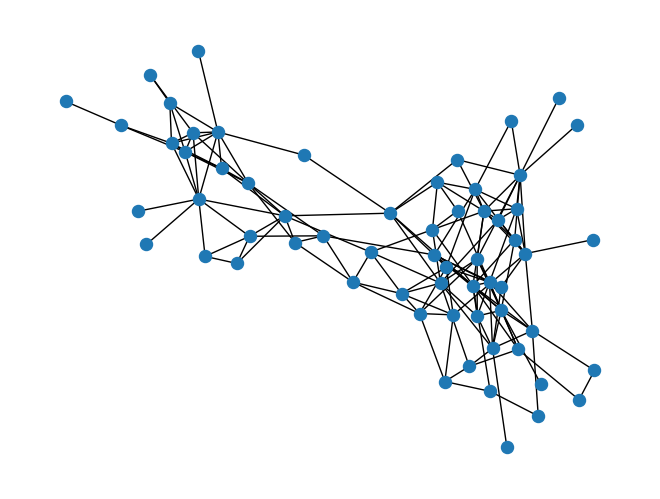

In [5]:
nx.draw(nx_graph_dolphins, pos=pos, node_size=75)

Как вы думаете, как стоило бы разделить этот граф на два сообщества?

Возможно, есть смысл преобразовать список ребер в какую-то другую структуру данных (еще раз):

In [198]:
import pandas as pd

#И вот мы снова тут. Ну а что я тут делал? А я сделала то же, что и в прошлый раз, а потом это все в граф и граф показать :з

edges_path = "data/dolphins/edges.csv"

edges_df = pd.read_csv(edges_path, sep = r"\s+", names = ["s", "w"], dtype = int)

graph_dolphins = {i: set() for i in range(num_nodes_dolphins)}
for _, row in edges_df.iterrows():
    s, w = int(row["s"]), int(row["w"])
    graph_dolphins[s].add(w)
    graph_dolphins[w].add(s)

for i in range(num_nodes_dolphins):
    print(f'{i}: {graph_dolphins.get(i, [])}')

nx_graph_dolphins = nx.Graph()
nx_graph_dolphins.add_edges_from(edges_df.to_numpy())

0: {40, 10, 42, 14, 15, 47}
1: {36, 41, 17, 19, 54, 26, 27, 28}
2: {10, 42, 61, 44}
3: {8, 59, 14}
4: {51}
5: {56, 9, 13, 57}
6: {9, 13, 17, 54, 56, 57}
7: {40, 19, 54, 27, 30}
8: {3, 37, 45, 20, 59, 28}
9: {32, 5, 6, 41, 13, 17, 57}
10: {0, 2, 42, 47, 29}
11: {51}
12: {33}
13: {32, 5, 6, 9, 41, 17, 54, 57}
14: {0, 33, 34, 3, 37, 38, 40, 43, 16, 50, 52, 24}
15: {0, 40, 45, 18, 55, 24, 59}
16: {33, 37, 38, 14, 50, 20}
17: {1, 6, 9, 13, 22, 25, 27, 57, 31}
18: {45, 15, 51, 20, 21, 24, 29}
19: {54, 1, 30, 7}
20: {36, 38, 8, 44, 47, 16, 18, 50, 28}
21: {33, 37, 45, 18, 51, 29}
22: {17}
23: {51, 36, 45}
24: {45, 14, 15, 18, 51, 29}
25: {17, 26, 27}
26: {1, 27, 25}
27: {1, 7, 17, 25, 26}
28: {1, 8, 47, 20, 30}
29: {35, 10, 43, 45, 18, 51, 52, 21, 24}
30: {7, 42, 47, 19, 28}
31: {17}
32: {9, 60, 13}
33: {34, 37, 38, 40, 43, 12, 14, 16, 50, 21}
34: {33, 37, 44, 14, 49}
35: {29}
36: {1, 37, 39, 40, 20, 23, 59}
37: {33, 34, 36, 8, 40, 43, 45, 14, 16, 21, 61}
38: {33, 43, 44, 14, 16, 20, 52, 58}


Реализуйте алгоритм Гирвана-Ньюмана:

1. Вычислите центральность для всех ребер в графе.
2. Удалите ребро с наибольшим значением центральности.
3. Найдите связные компоненты графа.
4. Алгоритм завершает работу если количество связных компонент равно целевому количеству сообществ или каждая связная компонента состоит только из одной вершины. В противном случае мы возвращаемся к шагу 1.

Обратите внимание, что алгоритм Гирвана-Ньюмана это [метод иерархической кластеризации с разделением (top-down)](https://en.wikipedia.org/wiki/Hierarchical_clustering).

In [209]:
from copy import deepcopy

In [241]:
def get_connected_components(graph):
    #Пум, пум, надо найти компоненты связности, пум, пум.
    
    visited = set() #Тип вершины к которым зашли в гости.
    connected_components = [] #Тип найденные компоненты.

    for w in graph:
        if w not in visited:
            component = set()
            Q = deque([w])
            visited.add(w)
            while Q:
                v = Q.popleft()
                component.add(v)
                for w in graph[v]:
                    if w not in visited:
                        Q.append(w)
                        visited.add(w)

            component = frozenset(component)
            connected_components.append(component)    

    return connected_components


def girvan_newman_algorithm(graph, stop_after_k_communities=None):
    """
    Compute hierarchical graph node clustering using the Girvan-Newman algorithm.
    
    Returns:
        communities_history - a list containing the communities after each separation. Each element of this
            list is a frozenset of frozensets: each community is represented by a frozenset of node ids, and each
            element of the returned list is a frozenset of these frozensets. communities_history[0] is a frozenset
            with one element, which is a frozenset containing all node ids. communities_history[1] is a frozenset
            with two elements, communities_history[2] is a frozenset with three elements, etc.
            If stop_after_k_communities is None, then communities_history[-1] is a frozenset with num_nodes
            elements, each one being a frozenset with one node id, otherwise communities_history[-1] is
            a frozenset with stop_after_k_communities elements.
    """
    graph = deepcopy(graph) 
    nx_graph = nx.Graph()
    
    for v, w in graph.items():
        for w in w:
            nx_graph.add_edge(v, w)

    communities_history = []  
    
    while True:
        #Тут просто вычисляем betweenness centrality для ребер графа.
        CB_edges = nx.edge_betweenness_centrality(nx_graph)
        if not CB_edges:
            break
            
        #Время найти ребро с макс центральность и удалить его, что кстати жестоко.
        max_edge = max(CB_edges.values())
        edges_to_remove = sorted(
            [edge for edge in CB_edges if CB_edges[edge] == max_edge],
            key = lambda x: (min(x), sum(x)) 
        )
        edge_to_remove = edges_to_remove[0]
        nx_graph.remove_edge(edge_to_remove[0], edge_to_remove[1])
        
        #Обнова графа
        updated_graph = {w: list(nx_graph.neighbors(w)) for w in nx_graph.nodes}
        new_components = get_connected_components(updated_graph)

        if stop_after_k_communities and len(communities_history) >= stop_after_k_communities:
            break
        
        if not communities_history or frozenset(new_components) != communities_history[-1]:
            communities_history.append(frozenset(new_components))
        
        #Одиночки :(
        if all(len(component) == 1 for component in new_components):
            break
    
    return communities_history


In [242]:
communities_history = girvan_newman_algorithm(graph_dolphins)

In [243]:
one_community = set([frozenset(range(num_nodes_dolphins))])
singleton_communities = set(frozenset([node_id]) for node_id in range(num_nodes_dolphins))
penultimate_communities = singleton_communities.copy()
penultimate_communities.remove(frozenset([53]))
penultimate_communities.remove(frozenset([61]))
penultimate_communities.add(frozenset([53, 61]))

one_community = frozenset(one_community)
singleton_communities = frozenset(singleton_communities)
penultimate_communities = frozenset(penultimate_communities)

assert communities_history[0] == one_community
assert communities_history[-1] == singleton_communities
assert communities_history[-2] == penultimate_communities

In [244]:
import pickle

In [245]:
with open('data/dolphins/communities_history.pickle', 'rb') as file:
    communities_history_gt = pickle.load(file)

In [246]:
assert communities_history == communities_history_gt

In [247]:
communities_history_25 = girvan_newman_algorithm(graph_dolphins, stop_after_k_communities=25)

In [248]:
assert communities_history_25 == communities_history_gt[:25]

Давайте посмотрим на граф после первого разделения связного компонента (т. е. когда появляются две сообщества).

Давайте посмотрим на граф после первого разделения компоненты связности:

In [249]:
two_communities = list(communities_history[1])

In [250]:
def get_community_id(communities, v):
    for i, community in enumerate(communities):
        if v in community:
            return i


In [251]:
edges_to_remove = [(u, v) for u, v in nx_graph_dolphins.edges
                   if get_community_id(two_communities, u) != get_community_id(two_communities, v)]

In [252]:
nx_graph_dolphins_two_communities = nx_graph_dolphins.copy()
nx_graph_dolphins_two_communities.remove_edges_from(edges_to_remove)

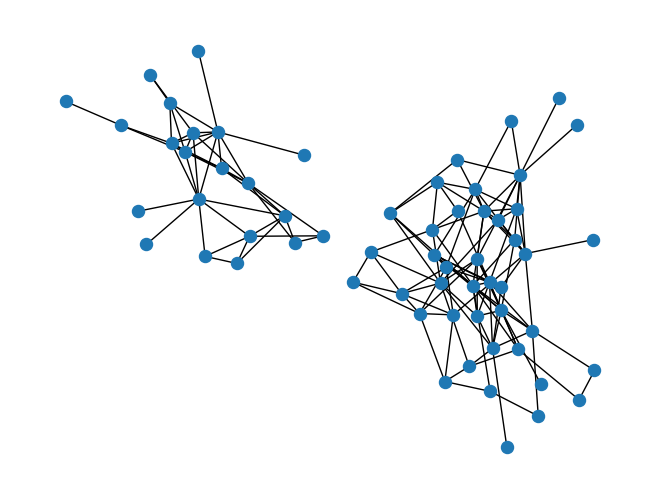

In [253]:
nx_graph_dolphins_two_communities = nx_graph_dolphins.copy()
nx_graph_dolphins_two_communities.remove_edges_from(edges_to_remove)
nx.draw(nx_graph_dolphins_two_communities, pos=pos, node_size=75)

Похоже ли это на то, что вы ожидали увидеть?

Выше было указано, что алгоритм Гирвана-Ньюмана производит иерархическую кластеризацию, а значит его можно визуализировать с помощью [дендрограммы](https://en.wikipedia.org/wiki/Dendrogram). Давайте сделаем это:

In [254]:
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plt

In [256]:
def get_linkage_matrix_from_communities_history(communities_history):
    n = len(communities_history[-1])
    community_ids = {frozenset([i]): i for i in range(n)}
    linkage_matrix = np.array([[np.nan, np.nan, i + 1, np.nan] for i in range(len(communities_history) - 1)])
    for i in range(len(communities_history) - 1):
        communities_old = communities_history[-i - 1]
        communities_new = communities_history[-i - 2]
        
        merged_communities = list(communities_old - communities_new)
        assert len(merged_communities) == 2
        merged_communities_ids = [community_ids[community] for community in merged_communities]
        linkage_matrix[i, 0] = merged_communities_ids[0]
        linkage_matrix[i, 1] = merged_communities_ids[1]
        linkage_matrix[i, 3] = len(merged_communities[0]) + len(merged_communities[1])
        
        new_community = list(communities_new - communities_old)
        assert len(new_community) == 1
        new_community = new_community[0]
        community_ids[new_community] = n + i
    
    return linkage_matrix


In [257]:
linkage_matrix = get_linkage_matrix_from_communities_history(communities_history)

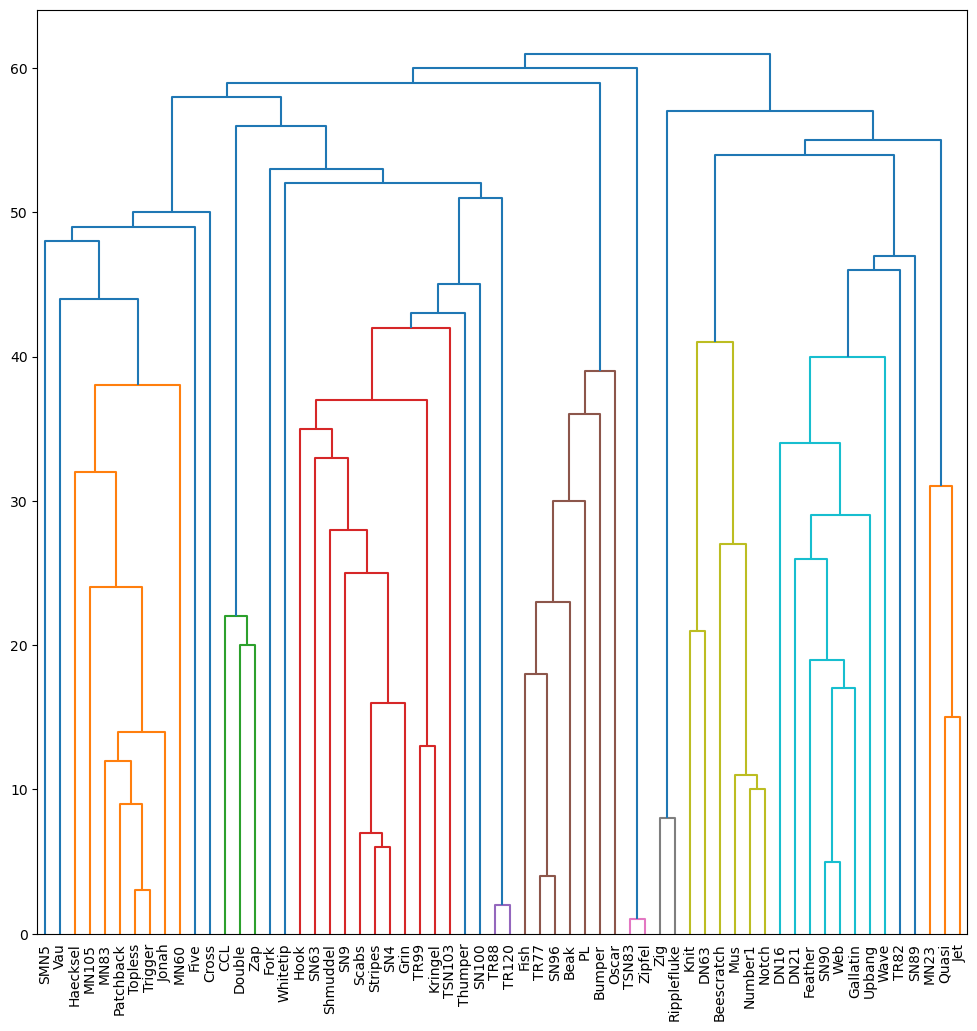

In [258]:
plt.figure(figsize=(12, 12))
dendrogram(linkage_matrix, labels=names, leaf_font_size=10)
plt.show()

После отладки алгоритма на меньшем графе, можно вернуться к Citeseer -- попробуем найти в графе цитирований 25 сообществ (это может занять около получаса):

In [259]:
%%time
communities_history = girvan_newman_algorithm(graph_citeseer, stop_after_k_communities=25)

CPU times: total: 4min 42s
Wall time: 19min 46s


In [260]:
with open('data/planetoid/citeseer/communities_history.pickle', 'rb') as file:
    communities_history_gt = pickle.load(file)

In [261]:
assert communities_history == communities_history_gt

В наборе данных Citeseer есть метки вершин, соответствующие исследовательской области публикаций. Давайте сравним найденные алгоритмом Гирвана-Ньюмана сообщества с этими метками: для сравнения двух кластеризаций с разным количеством кластеров мы можем использовать [скорректированный индекс Рэнда](https://en.wikipedia.org/wiki/Rand_index). Индекс принимает значения в диапазоне $[-0,5; \; 1]$ -- чем выше его значение, тем более похожи две кластеризации. 

Вычислим с каким количеством кластеров кластеризация Гирвана-Ньюмана больше всего похожа на метки вершин:

In [262]:
labels_citeseer = data_citeseer.y.tolist()

In [263]:
from sklearn.metrics import adjusted_rand_score

In [264]:
num_communities_to_adj_rand_index = {}
for i, communities in enumerate(communities_history, start=1):
    community_ids = [get_community_id(communities, v) for v in range(num_nodes_citeseer)]
    num_communities_to_adj_rand_index[i] = adjusted_rand_score(labels_true=labels_citeseer,
                                                               labels_pred=community_ids)

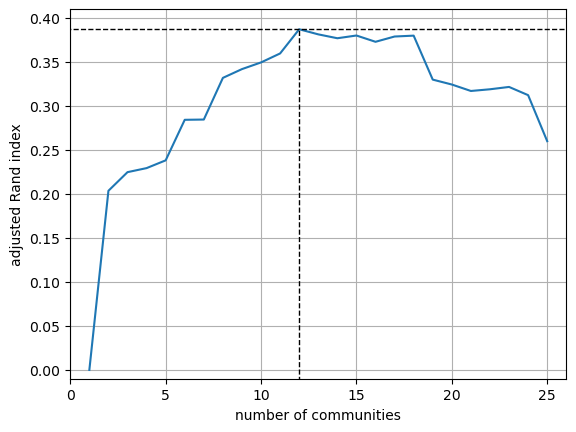

In [265]:
plt.plot(num_communities_to_adj_rand_index.keys(), num_communities_to_adj_rand_index.values())

argmax_ari, max_ari = max(num_communities_to_adj_rand_index.items(), key=lambda x: x[1])

plt.hlines(max_ari, xmin=-1, xmax=26, color='black', linestyle='dashed', linewidth=1)
plt.vlines(argmax_ari, ymin=-1, ymax=max_ari, color='black', linestyle='dashed', linewidth=1)

plt.xlim(0, 26)
plt.ylim(-0.01, 0.41)

plt.xlabel('number of communities')
plt.ylabel('adjusted Rand index')
plt.grid()

plt.show()